# 2A.ml - Arbres de décision / Random Forest

Classification, régression, visualisation avec des méthodes ensemblistes (arbres, forêts, ...).

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

### Description du problème

Le code suivant télécharge les données nécessaires [salaries2010.zip](http://www.xavierdupre.fr/enseignement/complements/salaries2010.zip).

Le machine learning peut se résumer à la construction d'une fonction de prédiction $Y=f(X) + \epsilon$. $f$ est le plus souvent le résultat d'une minimisation de l'erreur $\sum_i E(Y_i,f(X_i))$ où $(X_i,Y_i)$ est une liste de couples (features, cible). Les [arbres de décision](http://fr.wikipedia.org/wiki/Arbre_de_d%C3%A9cision) sont des modèles assez faciles à apprendre et ils ont l'avantage d'accepter des [features](http://en.wikipedia.org/wiki/Feature_%28machine_learning%29) continues et discrètes. Pour cet exercice, on reprend la base des salariés vu dans un précédent notebook et on va essayer de prédire le salaire en fonction de plus de variables que l'âge ou le sexe :

In [4]:
import os
if not os.path.exists("salaries2010.db3"):
    import pyensae
    db3 = pyensae.download_data("salaries2010.zip")

import sqlite3, pandas
con = sqlite3.connect("salaries2010.db3")
df = pandas.io.sql.read_sql("select * from varmod", con)
con.close()

values = df[ df.VARIABLE == "TRNETTOT"].copy()

def process_intervalle(s):
    if "euros et plus" in s : 
        return float ( s.replace("euros et plus", "").replace(" ","") )
    spl = s.split("à")
    if len(spl) == 2 : 
        s1 = spl[0].replace("Moins de","").replace("euros","").replace(" ","")
        s2 = spl[1].replace("Moins de","").replace("euros","").replace(" ","")
        return (float(s1)+float(s2))/2
    else : 
        s = spl[0].replace("Moins de","").replace("euros","").replace(" ","")
        return float(s)/2

values["montant"] = values.apply(lambda r : process_intervalle(r ["MODLIBELLE"]), axis = 1)

con = sqlite3.connect("salaries2010.db3")
data = pandas.io.sql.read_sql("select TRNETTOT,AGE,SEXE,DEPT,DEPR,TYP_EMPLOI,PCS,CS,CONT_TRAV,CONV_COLL from salaries", con)
con.close()

salaires = data.merge ( values, left_on = "TRNETTOT", right_on="MODALITE" )
salaires.dropna(inplace=True)
salaires.head()

,TRNETTOT,AGE,SEXE,DEPT,DEPR,TYP_EMPLOI,PCS,CS,CONT_TRAV,CONV_COLL,VARIABLE,MODALITE,MODLIBELLE,montant
0,14,50.0,1,,972,O,628G,62,ZZZ,,TRNETTOT,14,18 000 à 19 999 euros,18999.5
1,14,41.0,1,75,75,O,354C,35,CDD,1734,TRNETTOT,14,18 000 à 19 999 euros,18999.5
2,14,29.0,1,75,75,O,373C,37,CDD,0014,TRNETTOT,14,18 000 à 19 999 euros,18999.5
3,14,30.0,1,75,75,O,651A,65,CDD,9999,TRNETTOT,14,18 000 à 19 999 euros,18999.5
4,14,55.0,1,78,92,O,623E,62,ZZZ,,TRNETTOT,14,18 000 à 19 999 euros,18999.5


Le module scikit-learn n'accepte pas les features sous forme de chaînes de caractères :
* [Encoding categorical features](http://scikit-learn.org/stable/modules/feature_extraction.html#dict-feature-extraction)
* [Loading features from dicts](http://scikit-learn.org/stable/modules/feature_extraction.html#loading-features-from-dicts)
* [Vectorizing a Pandas dataframe for Scikit-Learn](http://stackoverflow.com/questions/20024584/vectorizing-a-pandas-dataframe-for-scikit-learn)

Il faut transformer les variables qui ne sont pas numériques (et non ordonnées) en variables booléennes (on fait cela sur un échantillon d'abord) :

In [5]:
import random
salaires["rnd"] = salaires.apply (lambda r : random.randint(0,50),axis=1)
ech = salaires [ salaires.rnd == 0 ]

La taille de l'échantillon doit être ajustée en fonction de la mémoire de l'ordinateur et il est aussi préférable de commencer avec un échantillon petit. Le développement du modèle prend moins de temps. On agrandit la taille de l'échantillon quand tout fonctionne bien (on perd souvent pas mal de temps parce que le type d'une variable n'est pas celui attendu, qu'on s'est trompé de nom, qu'une valeur est manquante...).

In [6]:
X,Y = ech[["AGE","SEXE","TYP_EMPLOI","CONT_TRAV"]], ech[["montant"]]
Xd = X.T.to_dict().values()
X.shape

(43111, 4)

On transforme les variables sous forme de chaînes de caractères en variables binaires :

In [7]:
from sklearn.feature_extraction import DictVectorizer
prep = DictVectorizer()
Xt = prep.fit_transform(Xd).toarray()

``Xt`` est un [numpy.ndarray](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html) mais la variable ``prep`` a conservé le nom des features.

In [8]:
prep.feature_names_

['AGE',
 'CONT_TRAV=APP',
 'CONT_TRAV=AUT',
 'CONT_TRAV=CDD',
 'CONT_TRAV=CDI',
 'CONT_TRAV=TTP',
 'CONT_TRAV=ZZZ',
 'SEXE=',
 'SEXE=1',
 'SEXE=2',
 'TYP_EMPLOI=A',
 'TYP_EMPLOI=O',
 'TYP_EMPLOI=X']

**Remarque :** On transforme une variable catégorielle en une série de variables booléennes mais lorsque les catégories sont exclusives, une observation est nécessairement dans l'une d'elles. La somme des variables booléennes qui en découlent est égale à 1. Cela revient à créer une séries de variables dont la somme est corrélée à une constante : ce cas est à éviter lors d'un modèle linéaire comme la régression. Il faut enlever une variable. Comme on cale un arbre de décision par la suite, ce n'est pas indispensable.

On entraîne l'arbre, on limite la profondeur à 3 histoire de pouvoir visualiser l'arbre résultant. Ce n'est certainement pas assez puisque $2^3=8$ = le nombre de feuilles est un nombre inférieure au nombres de tranches de salaires possibles.

In [9]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(min_samples_leaf=10, max_depth=3)
clf = clf.fit(Xt,Y)
clf.score(Xt,Y)

0.21069611975253544

On représente l'arbre de décision (et ça devient un peu complexe) :

In [10]:
from sklearn.tree import export_graphviz
export_graphviz(clf, out_file="arbre.dot") 

Pour visualiser l'arbre, il faut installer [graphviz](http://www.graphviz.org/) et lancer la commande  (il faudra sans doute remplacer le chemin vers votre installation de Graphviz).

In [11]:
import sys
cwd = os.getcwd()
if sys.platform.startswith("win"):
    exe = 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\dot.exe'
    if not os.path.exists(exe):
        raise FileNotFoundError(exe)
    exe = '"{0}"'.format(exe)
else:
    exe = "dot"
cmd = '"{0}" -Tpng {1}\\arbre.dot -o {1}\\arbre.png'.format(exe, cwd)

In [12]:
os.system(cmd)

0

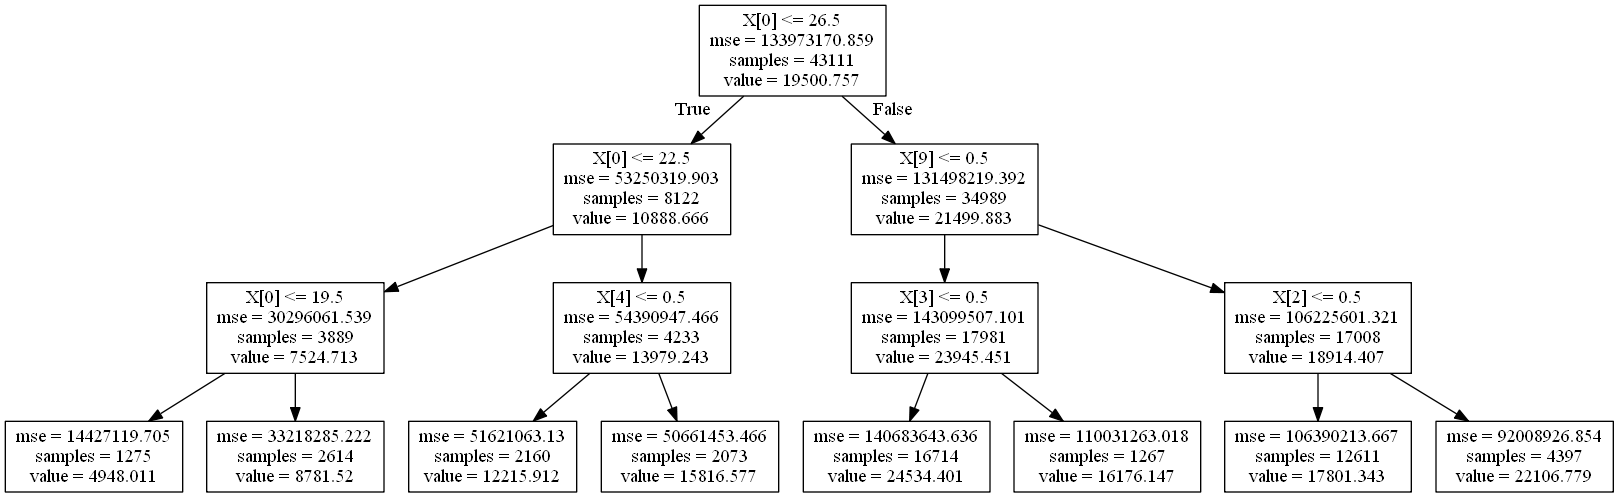

In [13]:
from IPython.core.display import Image
Image("arbre.png")

Dans un notebook, le javascript peut être utilisé pour tracer de le graphe (voir [Visualiser un arbre de décision](http://www.xavierdupre.fr/app/papierstat/helpsphinx/notebooks/decision_tree_visualization.html)).

In [14]:
from jyquickhelper import RenderJsVis
dot = export_graphviz(clf, out_file=None, feature_names=prep.feature_names_)
RenderJsVis(dot=dot, height="400px", layout='hierarchical')

Oups... j'ai oublié de séparer base d'apprentissage et base de test. Il ne restera plus qu'à tracer la courbe ROC : [Receiver operating characteristic (ROC)](http://scikit-learn.org/0.11/auto_examples/plot_roc.html).

### Exercice 1 : Bases d'apprentissage, test, courbes

A vous de jouer. Quelques idées :

* [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
* [random forest](http://blog.yhathq.com/posts/random-forests-in-python.html)

### Exercice 2 : Courbes ROC
    
On retourne le problème, on essaye de prévoir le sexe en fonction des autres variables dont le salaire.

* [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)